✅ Data extraction complete. Shape: (466, 8)

📊 Initial Data Overview:
                                          battery  battery_central  \
file                                                                 
run_wm1e-05_wc0p1_wt0p9.nc            1716.502446         4.085319   
run_wm0p43333_wc0p03333_wt0p53333.nc   287.502374         0.009606   
run_wm0p03333_wc0p66667_wt0p3.nc       660.229112         0.026169   
run_wm0p33333_wc0p6_wt0p06667.nc       321.567798         4.309860   
run_wm0p36667_wc0p2_wt0p43333.nc       307.664939         0.003419   

                                      curtailment           pv  \
file                                                             
run_wm1e-05_wc0p1_wt0p9.nc             573.609472  1651.569346   
run_wm0p43333_wc0p03333_wt0p53333.nc   792.607919   807.482247   
run_wm0p03333_wc0p66667_wt0p3.nc       725.287143  1385.687634   
run_wm0p33333_wc0p6_wt0p06667.nc       786.401929  1391.233041   
run_wm0p36667_wc0p2_wt0p43333.nc       781.

/Users/tomdebruin/miniforge3/envs/calliope/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


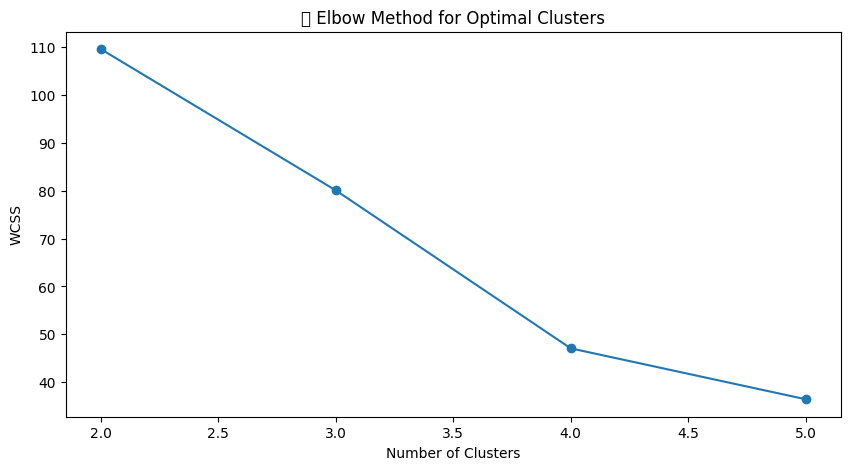

/Users/tomdebruin/miniforge3/envs/calliope/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


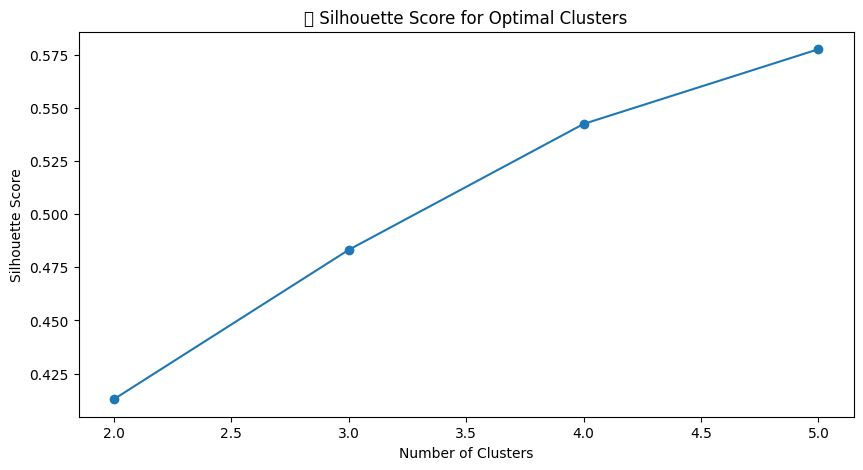

/Users/tomdebruin/miniforge3/envs/calliope/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


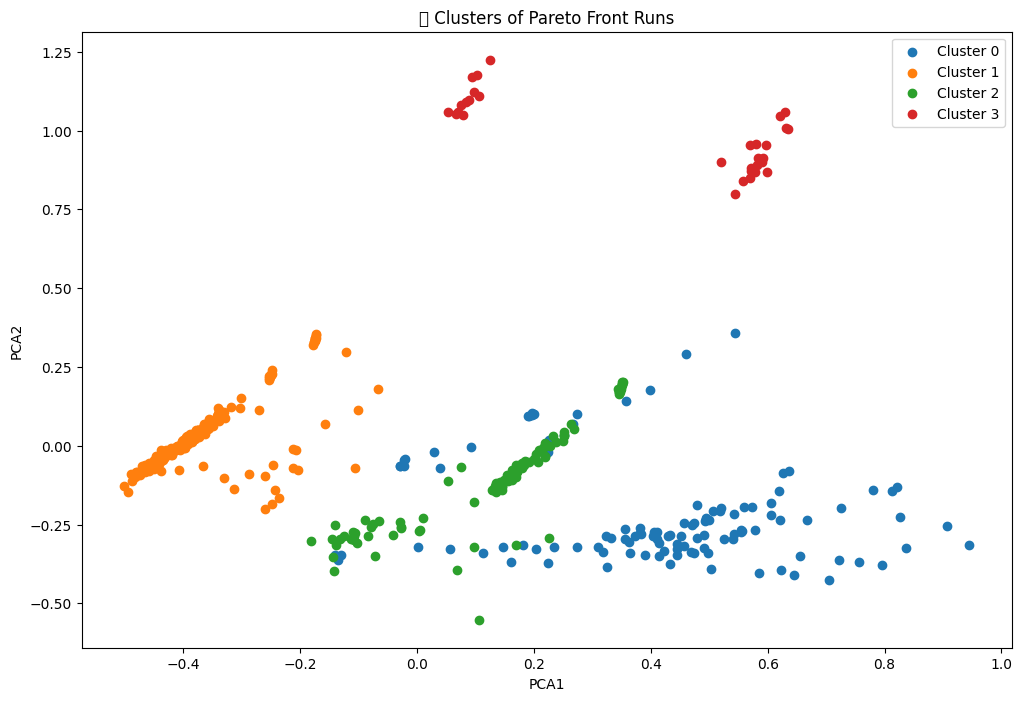


✅ Clustered data saved to 'pareto_front_clusters.csv'
             battery  battery_central  curtailment           pv  \
Cluster                                                           
0         217.617953        39.832038   813.824787  1360.490921   
1         369.588350         1.438889   777.758585   939.813793   
2         396.434180         0.012247   774.876215   973.647216   
3        1776.490565         2.971741   569.597310  1697.949737   

         sell_grid_power  solar_power  supply_grid_power  unmet_demand  
Cluster                                                                 
0             400.828528  1199.987453         338.009198  0.000000e+00  
1               8.545364  1199.988884         195.474392  0.000000e+00  
2              10.557838  1199.990038         388.313821  0.000000e+00  
3               7.578471  1199.998723         318.695043  3.151713e-10  


In [4]:
import os
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


# ----------------------------
# 📂 Paths and Directories
# ----------------------------
NC_FILES_DIR = "/Users/tomdebruin/Library/CloudStorage/OneDrive-DelftUniversityofTechnology/00 THESIS/00 Working Docs/V4/Experiments/pareto_fronts/pareto_front_runs5"

# Selected technologies
SELECTED_TECHS = [
    "battery", "battery_central", "unmet_demand", "curtailment",
    "solar_power", "pv", "supply_grid_power", "sell_grid_power"
]

# ----------------------------
# 📊 Data Extraction
# ----------------------------
def extract_flow_cap(file_path):
    """
    Extract 'flow_cap' values for selected technologies from an .nc file.
    """
    try:
        model = xr.open_dataset(file_path)
        df_capacity = (
            model["flow_cap"]
            .sum(dim="nodes")
            .to_dataframe(name="flow_cap")
            .reset_index()
        )
        
        # Filter for selected technologies
        df_capacity = df_capacity[df_capacity["techs"].isin(SELECTED_TECHS)]
        
        # Group to avoid duplicates and sum values
        df_capacity = df_capacity.groupby("techs", as_index=False).agg({"flow_cap": "sum"})
        
        # Ensure all selected technologies are included, even if missing in file
        for tech in SELECTED_TECHS:
            if tech not in df_capacity["techs"].values:
                df_capacity = pd.concat(
                    [df_capacity, pd.DataFrame({"techs": [tech], "flow_cap": [0]})],
                    ignore_index=True
                )
        
        return df_capacity.set_index("techs")["flow_cap"].to_dict()
    
    except KeyError as e:
        print(f"[ERROR] Missing required variable in {file_path}: {e}")
        return {tech: 0 for tech in SELECTED_TECHS}
    except Exception as e:
        print(f"[ERROR] Failed to process {file_path}: {e}")
        return {tech: 0 for tech in SELECTED_TECHS}


# ----------------------------
# 📑 Aggregate Data from Scenarios
# ----------------------------
def aggregate_pareto_runs(directory):
    """
    Aggregate flow_cap data from all .nc files in a directory.
    """
    data = []
    for file in os.listdir(directory):
        if file.endswith(".nc"):
            file_path = os.path.join(directory, file)
            flow_cap_data = extract_flow_cap(file_path)
            flow_cap_data['file'] = file
            data.append(flow_cap_data)
    
    df = pd.DataFrame(data).set_index('file')
    print("✅ Data extraction complete. Shape:", df.shape)
    return df


# ----------------------------
# 📊 Preprocessing
# ----------------------------
def preprocess_data(df):
    """
    Normalize and preprocess the dataset.
    """
    print("\n📊 Initial Data Overview:")
    print(df.head())
    
    # Fill missing values with zeros
    df.fillna(0, inplace=True)
    
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    print("✅ Data normalization complete.")
    return df_scaled, df


# ----------------------------
# 📉 Dimensionality Reduction (PCA)
# ----------------------------
def apply_pca(df_scaled):
    """
    Reduce dimensionality using PCA for visualization.
    """
    pca = PCA(n_components=2)
    df_pca = pca.fit_transform(df_scaled)
    print(f"📉 PCA Explained Variance Ratio: {pca.explained_variance_ratio_}")
    return pd.DataFrame(df_pca, columns=['PCA1', 'PCA2'])


# ----------------------------
# 🤖 Clustering
# ----------------------------
def determine_optimal_clusters(df_scaled, cluster_range=(2, 7)):
    """
    Determine optimal clusters using Elbow and Silhouette methods.
    """
    wcss = []
    silhouette_scores = []
    
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(df_scaled)
        wcss.append(kmeans.inertia_)
        if len(set(kmeans.labels_)) > 1:
            silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))
        else:
            silhouette_scores.append(float('nan'))
    
    # Elbow Method
    plt.figure(figsize=(10, 5))
    plt.plot(cluster_range, wcss, marker='o')
    plt.title('📈 Elbow Method for Optimal Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.show()

    # Silhouette Score
    plt.figure(figsize=(10, 5))
    plt.plot(cluster_range, silhouette_scores, marker='o')
    plt.title('📊 Silhouette Score for Optimal Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.show()
    
    optimal_clusters = int(input("🧐 Enter the optimal number of clusters based on the plots: "))
    return optimal_clusters


def perform_clustering(df_scaled, df_pca, n_clusters):
    """
    Perform final clustering and visualize the results.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(df_scaled)
    df_pca['Cluster'] = clusters
    
    plt.figure(figsize=(12, 8))
    for cluster in range(n_clusters):
        subset = df_pca[df_pca['Cluster'] == cluster]
        plt.scatter(subset['PCA1'], subset['PCA2'], label=f'Cluster {cluster}')
    
    plt.title('🔗 Clusters of Pareto Front Runs')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.legend()
    plt.show()
    
    return clusters


# ----------------------------
# 🚀 Main Function
# ----------------------------
def main():
    df = aggregate_pareto_runs(NC_FILES_DIR)
    df_scaled, df_clean = preprocess_data(df)
    df_pca = apply_pca(df_scaled)
    optimal_clusters = determine_optimal_clusters(df_scaled, cluster_range=range(2, 6))
    df_clean['Cluster'] = perform_clustering(df_scaled, df_pca, optimal_clusters)
    df_clean.to_csv('pareto_front_clusters.copy.csv')
    print("\n✅ Clustered data saved to 'pareto_front_clusters.csv'")
    print(df_clean.groupby('Cluster').mean())


if __name__ == '__main__':
    main()

In [5]:
import pandas as pd
import xarray as xr
import numpy as np
import os
import re

# ----------------------------
# 📂 Paths and Directories
# ----------------------------
CLUSTERS_CSV = "/Users/tomdebruin/Library/CloudStorage/OneDrive-DelftUniversityofTechnology/00 THESIS/00 Working Docs/V4/Experiments/perspectives/pareto_front_clusters.copy.csv"
RUNS_DIR = "/Users/tomdebruin/Library/CloudStorage/OneDrive-DelftUniversityofTechnology/00 THESIS/00 Working Docs/V4/Experiments/pareto_fronts/pareto_front_runs5"
OUTPUT_CSV = "representative_cluster_solutions_with_weights.csv"

# ----------------------------
# 🧠 Extract Weights from File Names
# ----------------------------
def extract_weights_from_name(file_name):
    """
    Extract weights (wm, wc, wt) from file names using regex.
    """
    match = re.match(r"run_wm([\d]+p[\d]+)_wc([\d]+p[\d]+)_wt([\d]+p[\d]+)\.nc", file_name)
    if match:
        wm, wc, wt = map(lambda x: float(x.replace('p', '.')), match.groups())
        return wm, wc, wt
    else:
        return None, None, None

# ----------------------------
# 🧠 Calculate Centroids
# ----------------------------
def calculate_centroids(df):
    """
    Calculate the centroid of each cluster based on flow_cap dimensions.
    """
    centroids = {}
    for cluster in df['Cluster'].unique():
        cluster_files = df[df['Cluster'] == cluster]['file']
        flow_caps = []
        
        for file in cluster_files:
            file_path = os.path.join(RUNS_DIR, file)
            try:
                ds = xr.open_dataset(file_path)
                flow_cap = ds['flow_cap'].sum(dim="nodes").to_dataframe(name='flow_cap').reset_index()
                flow_caps.append(flow_cap['flow_cap'].values)
            except Exception as e:
                print(f"❌ Failed to process {file}: {e}")
        
        if flow_caps:
            # Calculate centroid as the mean across runs
            centroids[cluster] = np.mean(flow_caps, axis=0)
    
    return centroids

# ----------------------------
# 📐 Find Nearest Solution
# ----------------------------
def find_nearest_to_centroid(df, centroids):
    """
    Find the file closest to the centroid of each cluster using Euclidean distance.
    Extract weights from filenames.
    """
    representative_runs = []
    
    for cluster, centroid in centroids.items():
        cluster_files = df[df['Cluster'] == cluster]['file']
        min_distance = float('inf')
        best_file = None
        
        for file in cluster_files:
            file_path = os.path.join(RUNS_DIR, file)
            try:
                ds = xr.open_dataset(file_path)
                flow_cap = ds['flow_cap'].sum(dim="nodes").to_dataframe(name='flow_cap').reset_index()
                run_vector = flow_cap['flow_cap'].values
                
                # Calculate Euclidean distance to centroid
                distance = np.linalg.norm(run_vector - centroid)
                
                if distance < min_distance:
                    min_distance = distance
                    best_file = file
            except Exception as e:
                print(f"❌ Failed to process {file}: {e}")
        
        if best_file:
            wm, wc, wt = extract_weights_from_name(best_file)
            representative_runs.append({
                'Cluster': cluster,
                'Representative_File': best_file,
                'weight_monetary': wm,
                'weight_co2': wc,
                'weight_transformer_congestion': wt
            })
    
    return pd.DataFrame(representative_runs)

# ----------------------------
# 🚀 Main Function
# ----------------------------
def main():
    # Load cluster assignments
    df = pd.read_csv(CLUSTERS_CSV)
    
    # Calculate centroids
    print("🧠 Calculating centroids...")
    centroids = calculate_centroids(df)
    
    # Find nearest solutions to centroids
    print("📐 Finding nearest solutions to centroids and extracting weights...")
    representative_df = find_nearest_to_centroid(df, centroids)
    
    # Save results
    representative_df.to_csv(OUTPUT_CSV, index=False)
    print(f"✅ Representative solutions with weights saved to '{OUTPUT_CSV}'")
    print(representative_df)


if __name__ == '__main__':
    main()

🧠 Calculating centroids...
📐 Finding nearest solutions to centroids and extracting weights...
✅ Representative solutions with weights saved to 'representative_cluster_solutions_with_weights.csv'
   Cluster               Representative_File  weight_monetary  weight_co2  \
0        3        run_wm1e-05_wc0p6_wt0p4.nc              NaN         NaN   
1        1  run_wm0p2_wc0p43333_wt0p36667.nc          0.20000     0.43333   
2        0          run_wm0p6_wc0p3_wt0p1.nc          0.60000     0.30000   
3        2  run_wm0p13333_wc0p06667_wt0p8.nc          0.13333     0.06667   

   weight_transformer_congestion  
0                            NaN  
1                        0.36667  
2                        0.10000  
3                        0.80000  


✅ Datasets successfully merged.
🔍 Merged data shape: (466, 9)


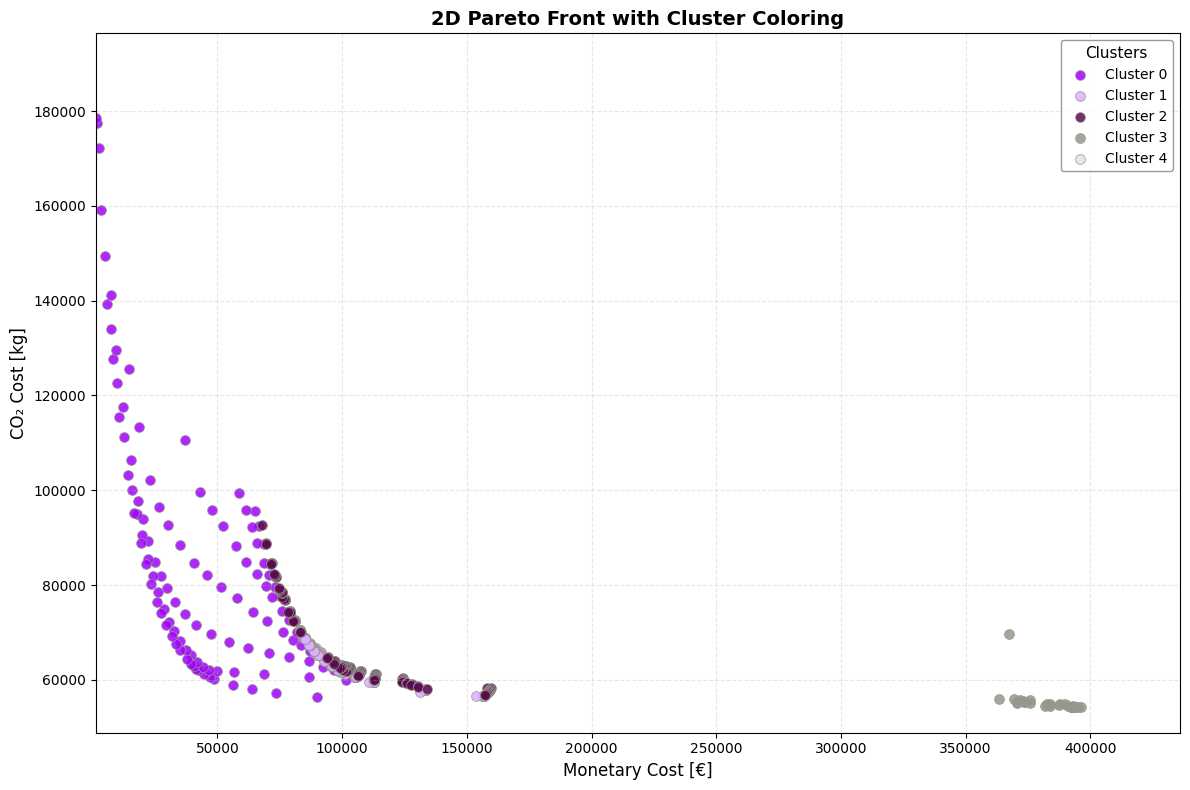

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# 🎨 Define Cluster Colors and Styles
# ----------------------------
# Accenture-inspired colors for 5 clusters
cluster_colors = {
    0: "#a100ff",  # Core Purple 1
    1: "#dcafff",  # Accent Purple 4
    2: "#5a0a4f",  # Darker Deep Purple
    3: "#96968c",  # Light Gray
    4: "#e6e6dc"   # Dark Gray
}

# Dot styles
dot_alpha = 0.85  # Slight transparency for better clarity
dot_size = 50     # Dot size for visibility
dot_edgecolor = "#96968c"  # Dark gray edge for clarity
dot_edgewidth = 0.6  # Slight edge thickness for definition

# ----------------------------
# 📊 2D Pareto Front Plot (Monetary vs CO₂)
# ----------------------------
def plot_pareto_front_with_clusters(data):
    """
    Plot a 2D Pareto Front colored by clusters.
    
    Parameters:
        data (pd.DataFrame): DataFrame containing 'monetary_cost', 'co2_cost', and 'Cluster'.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot each cluster explicitly
    for cluster in range(5):
        cluster_data = data[data['Cluster'] == cluster]
        ax.scatter(
            cluster_data["monetary_cost"],
            cluster_data["co2_cost"],
            color=cluster_colors[cluster],
            label=f'Cluster {cluster}',
            alpha=dot_alpha,
            s=dot_size,
            edgecolor=dot_edgecolor,
            linewidth=dot_edgewidth
        )
    
    # Set plot labels and title
    ax.set_xlabel("Monetary Cost [€]", fontsize=12)
    ax.set_ylabel("CO₂ Cost [kg]", fontsize=12)
    ax.set_title("2D Pareto Front with Cluster Coloring", fontsize=14, fontweight='bold')
    
    # Adjust axis ranges dynamically
    ax.set_xlim(data['monetary_cost'].min() * 0.9, data['monetary_cost'].max() * 1.1)
    ax.set_ylim(data['co2_cost'].min() * 0.9, data['co2_cost'].max() * 1.1)
    
    # Add legend for clusters
    ax.legend(
        title="Clusters",
        loc='upper right',
        fontsize=10,
        title_fontsize=11,
        frameon=True,
        edgecolor='gray'
    )
    
    # Improve grid appearance
    ax.grid(alpha=0.3, linestyle='--')
    
    # Fine-tune layout
    plt.tight_layout()
    plt.show()

# ----------------------------
# 📂 Load and Prepare Data
# ----------------------------
# File paths
PARETO_RESULTS_CSV = "/Users/tomdebruin/Library/CloudStorage/OneDrive-DelftUniversityofTechnology/00 THESIS/00 Working Docs/V4/Experiments/pareto_fronts/pareto_front_runs5/all_results.csv"
CLUSTERS_CSV = "/Users/tomdebruin/Library/CloudStorage/OneDrive-DelftUniversityofTechnology/00 THESIS/00 Working Docs/V4/Experiments/perspectives/pareto_front_clusters.copy.csv"

# Load datasets
pareto_data = pd.read_csv(PARETO_RESULTS_CSV)
clusters_data = pd.read_csv(CLUSTERS_CSV)

# Align filenames by renaming 'scenario' to 'file'
pareto_data.rename(columns={'scenario': 'file'}, inplace=True)

# Ensure both datasets have 'file' as string type
pareto_data['file'] = pareto_data['file'].astype(str)
clusters_data['file'] = clusters_data['file'].astype(str)

# Remove extensions and whitespace inconsistencies
pareto_data['file'] = pareto_data['file'].str.replace('.nc', '', regex=False).str.strip().str.lower()
clusters_data['file'] = clusters_data['file'].str.replace('.nc', '', regex=False).str.strip().str.lower()

# Merge datasets on 'file'
merged_data = pd.merge(pareto_data, clusters_data[['file', 'Cluster']], on='file', how='inner')
print("✅ Datasets successfully merged.")
print("🔍 Merged data shape:", merged_data.shape)

# ----------------------------
# 🚀 Plot the Pareto Front
# ----------------------------
plot_pareto_front_with_clusters(merged_data)

✅ Datasets successfully merged.
🔍 Merged data shape: (495, 9)
🔍 Representative runs shape: (3, 5)


KeyError: 'Cluster'

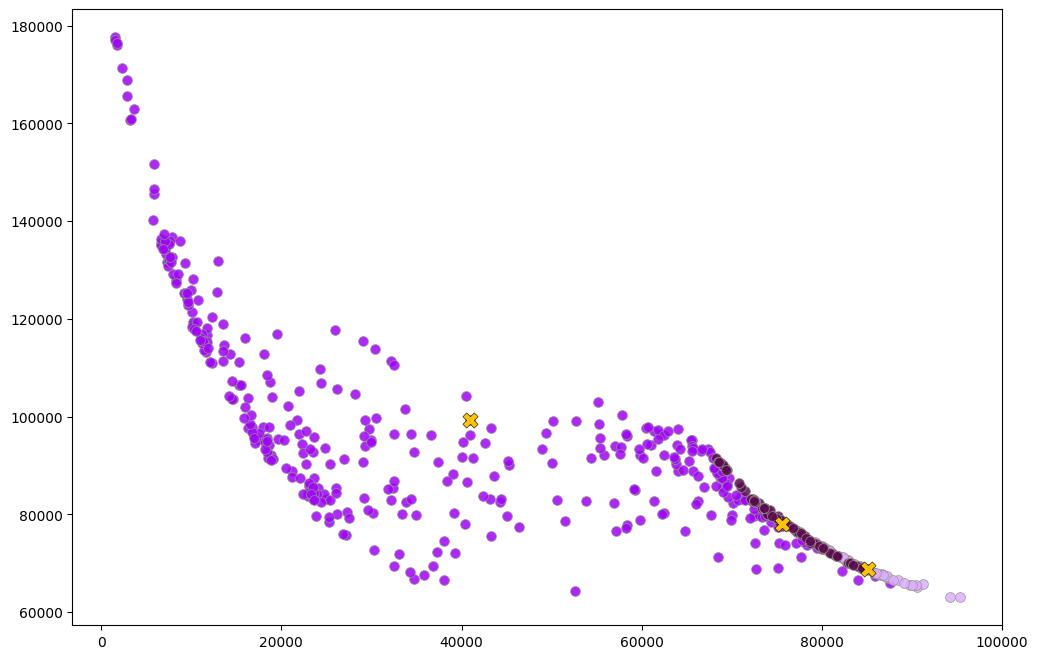

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths
PARETO_RESULTS_CSV = "/Users/tomdebruin/Library/CloudStorage/OneDrive-DelftUniversityofTechnology/00 THESIS/00 Working Docs/V4/Experiments/pareto_fronts/pareto_front_runs_dirichlet/all_results.csv"
CLUSTERS_CSV = "/Users/tomdebruin/Library/CloudStorage/OneDrive-DelftUniversityofTechnology/00 THESIS/00 Working Docs/V4/Experiments/perspectives/pareto_front_clusters.csv"
REPRESENTATIVE_CSV = "/Users/tomdebruin/Library/CloudStorage/OneDrive-DelftUniversityofTechnology/00 THESIS/00 Working Docs/V4/Experiments/perspectives/representative_cluster_solutions_with_weights.csv"

# ----------------------------
# 🎨 Define Cluster and Highlight Colors
# ----------------------------
# Cluster colors based on Accenture theme
cluster_colors = {
    0: "#a100ff",  # Core Purple 1
    1: "#dcafff",  # Accent Purple 4
    2: "#5a0a4f",  # Darker Deep Purple
    3: "#96968c",  # Light Gray
    4: "#e6e6dc"   # Dark Gray
}

# Highlight representative runs in bright yellow
highlight_color = "#FFC300"
highlight_size = 120  # Bigger size for visibility
highlight_edgecolor = "black"
highlight_edgewidth = 0.4  # Thinner edges
highlight_marker = "X"

# Regular dot styles
dot_alpha = 0.85
dot_size = 50
dot_edgecolor = "#96968c"
dot_edgewidth = 0.6


# ----------------------------
# 📊 2D Pareto Front Plot with Highlighted Representative Runs
# ----------------------------
def plot_pareto_front_with_highlighted_runs(data, representative_runs):
    """
    Plot a 2D Pareto Front colored by clusters and highlight representative runs.
    
    Parameters:
        data (pd.DataFrame): DataFrame containing 'monetary_cost', 'co2_cost', and 'Cluster'.
        representative_runs (pd.DataFrame): DataFrame containing representative run details.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot each cluster explicitly
    for cluster in data['Cluster'].unique():
        cluster_data = data[data['Cluster'] == cluster]
        ax.scatter(
            cluster_data["monetary_cost"],
            cluster_data["co2_cost"],
            color=cluster_colors.get(cluster, "#000000"),
            label=f'Cluster {cluster}',
            alpha=dot_alpha,
            s=dot_size,
            edgecolor=dot_edgecolor,
            linewidth=dot_edgewidth
        )
    
    # Highlight representative runs
    highlighted_data = pd.merge(data, representative_runs, on='file', how='inner')
    if not highlighted_data.empty:
        ax.scatter(
            highlighted_data["monetary_cost"],
            highlighted_data["co2_cost"],
            color=highlight_color,
            marker=highlight_marker,
            s=highlight_size,
            edgecolor=highlight_edgecolor,
            linewidth=highlight_edgewidth,
            label='Representative Runs'
        )
    
        # Annotate highlighted points with cluster numbers
        for _, row in highlighted_data.iterrows():
            ax.text(
                row["monetary_cost"],
                row["co2_cost"],
                f'{int(row["Cluster"])}',
                fontsize=10,
                fontweight='bold',
                color='black',
                ha='center',
                va='center'
            )
    
    # Set plot labels and title
    ax.set_xlabel("Monetary Cost [€]", fontsize=12)
    ax.set_ylabel("CO₂ Cost [kg]", fontsize=12)
    ax.set_title("2D Pareto Front with Cluster Coloring and Highlighted Representative Runs", fontsize=14, fontweight='bold')
    
    # Adjust axis ranges dynamically
    ax.set_xlim(data['monetary_cost'].min() * 0.9, data['monetary_cost'].max() * 1.1)
    ax.set_ylim(data['co2_cost'].min() * 0.9, data['co2_cost'].max() * 1.1)
    
    # Add legend for clusters and representative runs
    ax.legend(
        title="Clusters and Representative Runs",
        loc='upper right',
        fontsize=10,
        title_fontsize=11,
        frameon=True,
        edgecolor='gray'
    )
    
    # Improve grid appearance
    ax.grid(alpha=0.3, linestyle='--')
    
    # Fine-tune layout
    plt.tight_layout()
    plt.show()


# ----------------------------
# 📂 Load and Prepare Data
# ----------------------------
# Load datasets
pareto_data = pd.read_csv(PARETO_RESULTS_CSV)
clusters_data = pd.read_csv(CLUSTERS_CSV)
representative_data = pd.read_csv(REPRESENTATIVE_CSV)

# Align filenames by renaming 'scenario' to 'file'
pareto_data.rename(columns={'scenario': 'file'}, inplace=True)

# Ensure all datasets have 'file' as string type
pareto_data['file'] = pareto_data['file'].astype(str)
clusters_data['file'] = clusters_data['file'].astype(str)
representative_data['Representative_File'] = representative_data['Representative_File'].astype(str)

# Remove extensions and whitespace inconsistencies
pareto_data['file'] = pareto_data['file'].str.replace('.nc', '', regex=False).str.strip().str.lower()
clusters_data['file'] = clusters_data['file'].str.replace('.nc', '', regex=False).str.strip().str.lower()
representative_data['Representative_File'] = representative_data['Representative_File'].str.replace('.nc', '', regex=False).str.strip().str.lower()

# Merge datasets on 'file'
merged_data = pd.merge(pareto_data, clusters_data[['file', 'Cluster']], on='file', how='inner')

# Merge with representative data
representative_runs = representative_data.rename(columns={'Representative_File': 'file'})

print("✅ Datasets successfully merged.")
print("🔍 Merged data shape:", merged_data.shape)
print("🔍 Representative runs shape:", representative_runs.shape)

# ----------------------------
# 🚀 Plot the Pareto Front with Highlighted Runs
# ----------------------------
plot_pareto_front_with_highlighted_runs(merged_data, representative_runs)

In [39]:
import pandas as pd

# File paths


# Load datasets
pareto_data = pd.read_csv(PARETO_RESULTS_CSV)
clusters_data = pd.read_csv(CLUSTERS_CSV)
representative_data = pd.read_csv(REPRESENTATIVE_CSV)

# Print column names and sample of the data from each dataset
print("🎯 Column names and data preview from pareto_data:")
print(pareto_data.columns)
print(pareto_data.head())

print("\n🎯 Column names and data preview from clusters_data:")
print(clusters_data.columns)
print(clusters_data.head())

print("\n🎯 Column names and data preview from representative_data:")
print(representative_data.columns)
print(representative_data.head())

# ----------------------------
# Clean the file columns and align
# ----------------------------
# Ensure 'file' column exists in clusters_data and pareto_data
pareto_data['file'] = pareto_data['file'].astype(str).str.replace('.nc', '', regex=False).str.strip().str.lower()
clusters_data['file'] = clusters_data['file'].astype(str).str.replace('.nc', '', regex=False).str.strip().str.lower()

# Merge datasets on 'file'
merged_data = pd.merge(pareto_data, clusters_data[['file', 'Cluster']], on='file', how='inner')

# Ensure the 'Cluster' column is now available in the merged dataset
if 'Cluster' not in merged_data.columns:
    raise ValueError("❌ 'Cluster' column is missing in the merged data.")

print("\n✅ Merged data shape:", merged_data.shape)

# Merge with representative data
representative_data['Representative_File'] = representative_data['Representative_File'].astype(str).str.replace('.nc', '', regex=False).str.strip().str.lower()
representative_runs = representative_data.rename(columns={'Representative_File': 'file'})

# Verify if the merge was successful
final_data = pd.merge(merged_data, representative_runs, on='file', how='left')

print("\n✅ Final data after merging representative runs:")
print(final_data.head())

🎯 Column names and data preview from pareto_data:
Index(['scenario', 'total_cost', 'monetary_cost', 'co2_cost',
       'transformer_congestion_indicator', 'w_monetary', 'w_co2',
       'w_transformer'],
      dtype='object')
                            scenario     total_cost  monetary_cost  \
0  run_wm0p64277_wc0p30076_wt0p05647  483306.212788   24931.927492   
1  run_wm0p52385_wc0p05937_wt0p41678  222063.021953   80037.859201   
2  run_wm0p80112_wc0p17447_wt0p02441  577744.157169   11621.550977   
3  run_wm0p60814_wc0p34474_wt0p04713  485558.802482   26145.325615   
4  run_wm0p71467_wc0p17878_wt0p10655  385041.119313   37346.066733   

        co2_cost  transformer_congestion_indicator  w_monetary    w_co2  \
0   83030.170641                     375344.114656     0.64277  0.30076   
1   73416.681375                      68608.481377     0.52385  0.05937   
2  113141.828859                     452980.777333     0.80112  0.17447   
3   79994.636359                     379418.840508    

KeyError: 'file'